In [1]:
import os
import torch
import torchvision 
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
os.listdir('./monkey_images_dataset/training/training/')
os.listdir('./monkey_images_dataset/validation/validation/')

['n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9']

In [3]:
train_path = './monkey_images_dataset/training/training/'
test_path = './monkey_images_dataset/validation/validation/'

In [5]:
mean = [0.4363, 0.4328, 0.3291]
std = [0.2129, 0.2075, 0.2037]

train_transform = transforms.Compose([transforms.Resize((224,224)),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(10),
                                transforms.ToTensor(),
                                transforms.Normalize(torch.tensor(mean), torch.tensor(std))
                                ])

test_transform = transforms.Compose([transforms.Resize((224,224)),
                                transforms.ToTensor(),
                                transforms.Normalize(torch.tensor(mean), torch.tensor(std))
                                ])

In [6]:
train_dataset = torchvision.datasets.ImageFolder(root = train_path, transform=train_transform)
test_dataset = torchvision.datasets.ImageFolder(root = test_path, transform=test_transform)

In [7]:
def show_transformed_images(dataset):
    loader = torch.utils.data.DataLoader(dataset, batch_size=6, shuffle=False)
    batch = next(iter(loader))
    images, labels = batch
    
    grid = torchvision.utils.make_grid(images, nrow=3)
    plt.figure(figsize=(11,11))
    plt.imshow(np.transpose(grid, (1,2,0)))
    print('Labels', labels)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels tensor([0, 0, 0, 0, 0, 0])


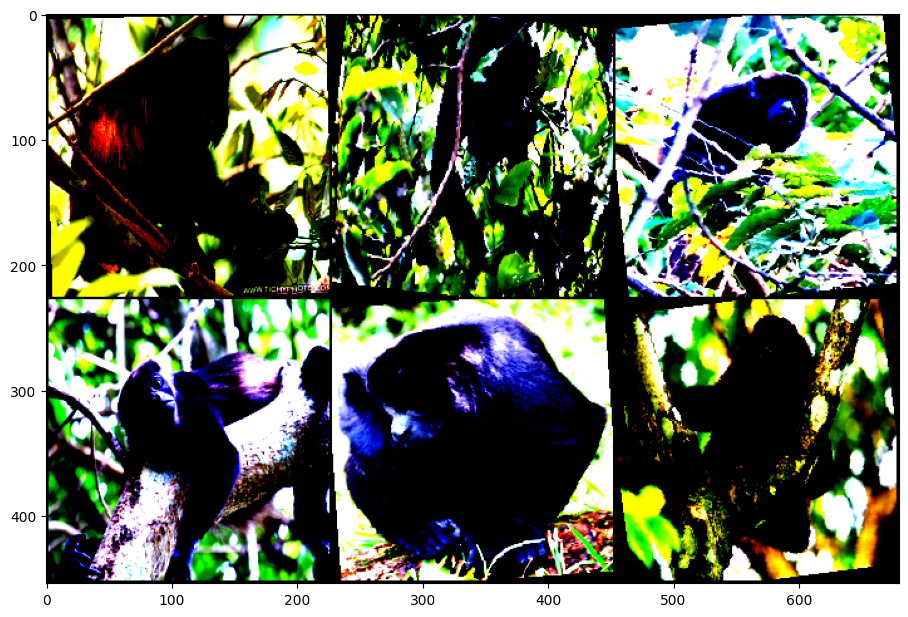

In [8]:
show_transformed_images(train_dataset)

In [9]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

In [ ]:
# YouTubeVideolink = https://youtu.be/ovZ_54IUSU4?si=oL5ju8MbBfu4gtti